# Installation of Packages

In [87]:
# !pip install -q tensorflow_datasets

# !pip install datasets

# !pip install keras_cv

# !pip install keras_hub

# Download Dataset from external source

# Importing packages

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import  metrics
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import ops
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
import keras
from tensorflow.keras.datasets import mnist

from tqdm import tqdm

# import tensorflow_datasets as tfds
# from datasets import load_dataset
# from keras.applications import EfficientNetB0
# import keras_cv
# import keras_hub

# Custom Functions

# Reading Data

In [89]:
(x_train, y_train), (x_val, y_val) =  mnist.load_data()

# Data Inspection / Visualization

In [90]:
print(f"x_train : {ops.shape(x_train)} and y_train : {ops.shape(y_train)}")
print(f"x_val : {ops.shape(x_val)} and y_test : {ops.shape(y_val)}")

x_train : (60000, 28, 28) and y_train : (60000,)
x_val : (10000, 28, 28) and y_test : (10000,)


In [91]:
x_train.dtype, y_train.dtype, x_val.dtype, y_val.dtype

(dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('uint8'))

In [92]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

  0%|          | 0/1 [02:34<?, ?it/s]


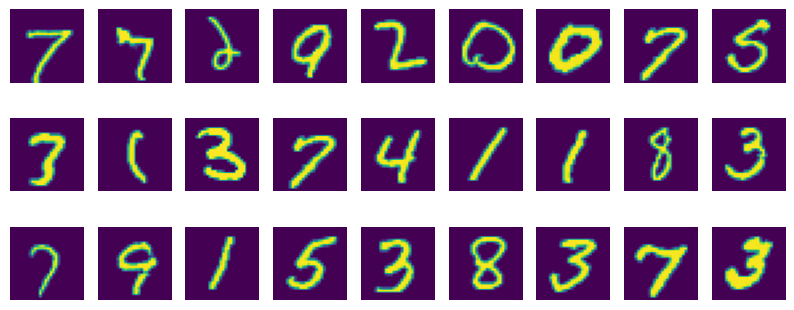

In [93]:
plt.figure(figsize=(10, 4))
for i in range(27):
    plt.subplot(3, 9,i+1)
    plt.imshow(x_train[np.random.choice(6000)])
    plt.axis("off")

# Data Preprocessing

In [94]:
def create_bags(input_data, input_labels, positive_class, bag_count, instance_count):
    bags = []
    bag_labels = []

    input_data = np.divide(input_data, 255.0)

    count = 0

    for _ in range(bag_count):
        index = np.random.choice(input_data.shape[0],  instance_count, replace=False)
        instances_data = input_data[index]
        instances_labels = input_labels[index]

        bag_label = 0

        if positive_class in instances_labels: 
            bag_label = 1
            count += 1
        
        bags.append(instances_data)
        bag_labels.append(np.array([bag_label]))
    
    print(f"Positive bags: {count}")
    print(f"Negative bags: {bag_count - count}")

    return (list(np.swapaxes(bags, 0, 1)), np.array(bag_labels))


In [95]:
POSITIVE_CLASS = 1
BAG_COUNT = 1000
VAL_BAG_COUNT = 300
BAG_SIZE = 3

In [96]:
train_data, train_labels = create_bags(
    x_train, y_train, POSITIVE_CLASS, BAG_COUNT, BAG_SIZE
)

Positive bags: 282
Negative bags: 718


In [97]:
val_data, val_labels = create_bags(
    x_val, y_val, POSITIVE_CLASS, VAL_BAG_COUNT, BAG_SIZE
)

Positive bags: 81
Negative bags: 219


# Data Postprocessing

# Model

In [98]:
class MILAttentionLayer(layers.Layer):
    """Implementation of the attention-based Deep MIL layer.

    Args:
      weight_params_dim: Positive Integer. Dimension of the weight matrix.
      kernel_initializer: Initializer for the `kernel` matrix.
      kernel_regularizer: Regularizer function applied to the `kernel` matrix.
      use_gated: Boolean, whether or not to use the gated mechanism.

    Returns:
      List of 2D tensors with BAG_SIZE length.
      The tensors are the attention scores after softmax with shape `(batch_size, 1)`.
    """

    def __init__(
        self,
        weight_params_dim,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        use_gated=False,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)

        self.v_init = self.kernel_initializer
        self.w_init = self.kernel_initializer
        self.u_init = self.kernel_initializer

        self.v_regularizer = self.kernel_regularizer
        self.w_regularizer = self.kernel_regularizer
        self.u_regularizer = self.kernel_regularizer

    def build(self, input_shape):
        # Input shape.
        # List of 2D tensors with shape: (batch_size, input_dim).
        input_dim = input_shape[0][1]

        self.v_weight_params = self.add_weight(
            shape=(input_dim, self.weight_params_dim),
            initializer=self.v_init,
            name="v",
            regularizer=self.v_regularizer,
            trainable=True,
        )

        self.w_weight_params = self.add_weight(
            shape=(self.weight_params_dim, 1),
            initializer=self.w_init,
            name="w",
            regularizer=self.w_regularizer,
            trainable=True,
        )

        if self.use_gated:
            self.u_weight_params = self.add_weight(
                shape=(input_dim, self.weight_params_dim),
                initializer=self.u_init,
                name="u",
                regularizer=self.u_regularizer,
                trainable=True,
            )
        else:
            self.u_weight_params = None

        self.input_built = True

    def call(self, inputs):
        # Assigning variables from the number of inputs.
        instances = [self.compute_attention_scores(instance) for instance in inputs]

        # Stack instances into a single tensor.
        instances = ops.stack(instances)

        # Apply softmax over instances such that the output summation is equal to 1.
        alpha = ops.softmax(instances, axis=0)

        # Split to recreate the same array of tensors we had as inputs.
        return [alpha[i] for i in range(alpha.shape[0])]

    def compute_attention_scores(self, instance):
        # Reserve in-case "gated mechanism" used.
        original_instance = instance

        # tanh(v*h_k^T)
        instance = ops.tanh(ops.tensordot(instance, self.v_weight_params, axes=1))

        # for learning non-linear relations efficiently.
        if self.use_gated:
            instance = instance * ops.sigmoid(
                ops.tensordot(original_instance, self.u_weight_params, axes=1)
            )

        # w^T*(tanh(v*h_k^T)) / w^T*(tanh(v*h_k^T)*sigmoid(u*h_k^T))
        return ops.tensordot(instance, self.w_weight_params, axes=1)

In [99]:
def plot(data, labels, bag_class, predictions=None, attention_weights=None):
    """ "Utility for plotting bags and attention weights.

    Args:
      data: Input data that contains the bags of instances.
      labels: The associated bag labels of the input data.
      bag_class: String name of the desired bag class.
        The options are: "positive" or "negative".
      predictions: Class labels model predictions.
      If you don't specify anything, ground truth labels will be used.
      attention_weights: Attention weights for each instance within the input data.
      If you don't specify anything, the values won't be displayed.
    """
    return  ## TODO
    labels = np.array(labels).reshape(-1)

    if bag_class == "positive":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

        else:
            labels = np.where(labels == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

    elif bag_class == "negative":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]
        else:
            labels = np.where(labels == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

    else:
        print(f"There is no class {bag_class}")
        return

    print(f"The bag class label is {bag_class}")
    for i in range(PLOT_SIZE):
        figure = plt.figure(figsize=(8, 8))
        print(f"Bag number: {labels[i]}")
        for j in range(BAG_SIZE):
            image = bags[j][i]
            figure.add_subplot(1, BAG_SIZE, j + 1)
            plt.grid(False)
            if attention_weights is not None:
                plt.title(np.around(attention_weights[labels[i]][j], 2))
            plt.imshow(image)
        plt.show()


# Plot some of validation data bags per class.
plot(val_data, val_labels, "positive")
plot(val_data, val_labels, "negative")

In [100]:
def create_model(instance_shape):
    # Extract features from inputs.
    inputs, embeddings = [], []
    shared_dense_layer_1 = layers.Dense(128, activation="relu")
    shared_dense_layer_2 = layers.Dense(64, activation="relu")
    for _ in range(BAG_SIZE):
        inp = layers.Input(instance_shape)
        flatten = layers.Flatten()(inp)
        dense_1 = shared_dense_layer_1(flatten)
        dense_2 = shared_dense_layer_2(dense_1)
        inputs.append(inp)
        embeddings.append(dense_2)

    # Invoke the attention layer.
    alpha = MILAttentionLayer(
        weight_params_dim=256,
        kernel_regularizer=regularizers.L2(0.01),
        use_gated=True,
        name="alpha",
    )(embeddings)

    # Multiply attention weights with the input layers.
    multiply_layers = [
        layers.multiply([alpha[i], embeddings[i]]) for i in range(len(alpha))
    ]

    # Concatenate layers.
    concat = layers.concatenate(multiply_layers, axis=1)

    # Classification output node.
    output = layers.Dense(2, activation="softmax")(concat)

    return models.Model(inputs, output)

In [101]:
def compute_class_weights(labels):
    # Count number of postive and negative bags.
    negative_count = len(np.where(labels == 0)[0])
    positive_count = len(np.where(labels == 1)[0])
    total_count = negative_count + positive_count

    # Build class weight dictionary.
    return {
        0: (1 / negative_count) * (total_count / 2),
        1: (1 / positive_count) * (total_count / 2),
    }

In [102]:
PLOT_SIZE = 3
ENSEMBLE_AVG_COUNT = 1

In [103]:
def train(train_data, train_labels, val_data, val_labels, model):
    # Train model.
    # Prepare callbacks.
    # Path where to save best weights.

    # Take the file name from the wrapper.
    file_path = "/tmp/best_model.weights.h5"

    # Initialize model checkpoint callback.
    model_checkpoint = callbacks.ModelCheckpoint(
        file_path,
        monitor="val_loss",
        verbose=0,
        mode="min",
        save_best_only=True,
        save_weights_only=True,
    )

    # Initialize early stopping callback.
    # The model performance is monitored across the validation data and stops training
    # when the generalization error cease to decrease.
    early_stopping = callbacks.EarlyStopping(
        monitor="val_loss", patience=10, mode="min"
    )

    # Compile model.
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Fit model.
    model.fit(
        train_data,
        train_labels,
        validation_data=(val_data, val_labels),
        epochs=3,
        class_weight=compute_class_weights(train_labels),
        batch_size=1,
        callbacks=[early_stopping, model_checkpoint],
        verbose=0,
    )

    # Load best weights.
    model.load_weights(file_path)

    return model


In [104]:
# Building model(s).
instance_shape = train_data[0][0].shape
models = [create_model(instance_shape) for _ in range(ENSEMBLE_AVG_COUNT)]

# Show single model architecture.
print(models[0].summary())

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_25      │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_26      │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_24          │ (None, 784)       │          0 │ input_layer_24[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_25          │ (None, 784)       │          0 │ input_layer_25[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_26          │ (None, 784)       │          0 │ input_layer_26[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │    100,480 │ flatten_24[0][0], │
│                     │                   │            │ flatten_25[0][0], │
│                     │                   │            │ flatten_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      8,256 │ dense_20[0][0],   │
│                     │                   │            │ dense_20[1][0],   │
│                     │                   │            │ dense_20[2][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alpha               │ [(None, 1),       │     33,024 │ dense_21[0][0],   │
│ (MILAttentionLayer) │ (None, 1), (None, │            │ dense_21[1][0],   │
│                     │ 1)]               │            │ dense_21[2][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_12         │ (None, 64)        │          0 │ alpha[0][0],      │
│ (Multiply)          │                   │            │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_13         │ (None, 64)        │          0 │ alpha[0][1],      │
│ (Multiply)          │                   │            │ dense_21[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_14         │ (None, 64)        │          0 │ alpha[0][2],      │
│ (Multiply)          │                   │            │ dense_21[2][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 192)       │          0 │ multiply_12[0][0… │
│ (Concatenate)       │                   │            │ multiply_13[0][0… │
│                     │                   │            │ multiply_14[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 2)         │        386 │ concatenate_4[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 142,146 (555.26 KB)

 Trainable params: 142,146 (555.26 KB)

 Non-trainable params: 0 (0.00 B)

None


# Compile

In [105]:
# Training model(s).
trained_models = [
    train(train_data, train_labels, val_data, val_labels, model)
    for model in tqdm(models)
]

100%|██████████| 1/1 [00:17<00:00, 17.30s/it]


# Fit

# Evaluation

In [108]:
def predict(data, labels, trained_models):
    # Collect info per model.
    models_predictions = []
    models_attention_weights = []
    models_losses = []
    models_accuracies = []

    for model in trained_models:
        # Predict output classes on data.
        predictions = model.predict(data)
        models_predictions.append(predictions)

        # Create intermediate model to get MIL attention layer weights.
        intermediate_model = keras.Model(model.input, model.get_layer("alpha").output)

        # Predict MIL attention layer weights.
        intermediate_predictions = intermediate_model.predict(data)

        attention_weights = np.squeeze(np.swapaxes(intermediate_predictions, 1, 0))
        models_attention_weights.append(attention_weights)

        loss, accuracy = model.evaluate(data, labels, verbose=0)
        models_losses.append(loss)
        models_accuracies.append(accuracy)

    print(
        f"The average loss and accuracy are {np.sum(models_losses, axis=0) / ENSEMBLE_AVG_COUNT:.2f}"
        f" and {100 * np.sum(models_accuracies, axis=0) / ENSEMBLE_AVG_COUNT:.2f} % resp."
    )

    return (
        np.sum(models_predictions, axis=0) / ENSEMBLE_AVG_COUNT,
        np.sum(models_attention_weights, axis=0) / ENSEMBLE_AVG_COUNT,
    )


# Evaluate and predict classes and attention scores on validation data.
class_predictions, attention_params = predict(val_data, val_labels, trained_models)

# Plot some results from our validation data.
plot(
    val_data,
    val_labels,
    "positive",
    predictions=class_predictions,
    attention_weights=attention_params,
)
plot(
    val_data,
    val_labels,
    "negative",
    predictions=class_predictions,
    attention_weights=attention_params,
)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
The average loss and accuracy are 0.07 and 98.67 % resp.


# Inference

# Misc